In [8]:
import torch
import importlib
import homework4
import numpy as np
import matplotlib.pyplot as plt
import torch.nn as nn


importlib.reload(homework4)

CNP = homework4.CNP
max_n_context = 5
max_n_target = 3

min_n_context = 3
min_n_target = 1

In [13]:
def log_prob_loss(output, target):
    #print(f"Output : {output} target: {target}")
    mean, sigma = output
    #print(f"Output: {output}, Target: {target}, Mean: {mean}, Sigma: {sigma}")
    dist = torch.distributions.Independent(torch.distributions.Normal(loc=mean, scale=sigma), 1)
    return -torch.mean(dist.log_prob(target))

def generate_samples(traj: torch.Tensor):

    n_context = np.random.randint(min_n_context, max_n_context+1)
    n_target = np.random.randint(min_n_target, max_n_target+1)

    rnd_indexes = torch.randint(0, len(traj), (n_context+n_target,))
    random_rows = traj[rnd_indexes] 
    rnd_indexes = rnd_indexes.float() / (len(traj) - 1)
    random_rows = torch.cat((rnd_indexes.unsqueeze(-1).float(), random_rows), dim=1)
    tensor_1 = random_rows[:n_context].unsqueeze(0)
    tensor_2 = random_rows[n_context:][...,:2].unsqueeze(0)
    tensor_3 = random_rows[n_context:][...,2:].unsqueeze(0)

    return tensor_1, tensor_2, tensor_3

def train():
    d_x = 2
    d_y = 4
    model = CNP([d_x,d_y], 128, 2, 0)
    model.train()
    training_data = np.load("states.npy")
    training_data = torch.tensor(training_data, dtype=torch.float32)

    training_data = torch.roll(training_data, shifts=1, dims=2)

    traj_count = len(training_data)
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
    loss_lst = []
    for i in range(100_000):
        traj_ind = np.random.randint(traj_count)
        traj = training_data[traj_ind]
        samples, target_x, target_y = generate_samples(traj)
        out = model(samples, target_x)
        loss = log_prob_loss(out, target_y)
        loss_lst.append(loss.item())
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        if i % 1000 == 0:
            print(f"Epoch {i} Loss: {loss.item()}")

    return loss_lst, model    
        
def test():
    d_x = 2
    d_y = 4
    model = CNP([d_x,d_y], 128, 2, 0)
    model.load_state_dict(torch.load("model.pth"))
    model.eval()
    test_data = np.load("states_test.npy")
    test_data = torch.tensor(test_data, dtype=torch.float32)
    test_data = torch.roll(test_data, shifts=1, dims=2)
    mse_ee_lst = []
    mse_obj_lst = []
    for i in range(100):
        rand_index = np.random.randint(len(test_data))
        traj = test_data[rand_index]

        samples, target_x, target_y = generate_samples(traj)
        out = model(samples, target_x)
        mean, _ = out
        mse_ee_lst.append(torch.mean((mean[0][0][:2] - target_y[0][0][:2])**2).item())
        mse_obj_lst.append(torch.mean((mean[0][0][2:] - target_y[0][0][2:])**2).item())

    mse_ee = np.mean(mse_ee_lst)
    mse_obj = np.mean(mse_obj_lst)
    std_ee = np.std(mse_ee_lst)
    std_obj = np.std(mse_obj_lst)

    plt.figure(figsize=(6, 4))
    plt.bar(["End-Effector", "Object"], [mse_ee, mse_obj], yerr=[std_ee, std_obj], capsize=5)
    plt.ylabel("Mean Squared Error")
    plt.title("Prediction Error Comparison")
    plt.show()
        


In [10]:
loss_lst, model = train() 
model.eval()
torch.save(model.state_dict(), "model.pth")

Epoch 0 Loss: 4.748893737792969
Epoch 1000 Loss: -6.440662384033203
Epoch 2000 Loss: -6.180334091186523
Epoch 3000 Loss: -4.680682182312012
Epoch 4000 Loss: -5.379692077636719
Epoch 5000 Loss: -7.0804901123046875
Epoch 6000 Loss: -3.6724612712860107
Epoch 7000 Loss: -7.446168422698975
Epoch 8000 Loss: -8.052331924438477
Epoch 9000 Loss: -7.609888076782227
Epoch 10000 Loss: -8.132766723632812
Epoch 11000 Loss: -9.375003814697266
Epoch 12000 Loss: -9.026283264160156
Epoch 13000 Loss: -10.592986106872559
Epoch 14000 Loss: -9.860407829284668
Epoch 15000 Loss: -7.3770952224731445
Epoch 16000 Loss: -7.4581217765808105
Epoch 17000 Loss: -9.534549713134766
Epoch 18000 Loss: -9.210395812988281
Epoch 19000 Loss: -10.661547660827637
Epoch 20000 Loss: -6.504521369934082
Epoch 21000 Loss: -6.197686195373535
Epoch 22000 Loss: -10.990629196166992
Epoch 23000 Loss: -9.056079864501953
Epoch 24000 Loss: -10.967799186706543
Epoch 25000 Loss: -9.99605941772461
Epoch 26000 Loss: -11.697174072265625
Epoch 2

/tmp/ipykernel_5892/1700833850.py:15: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


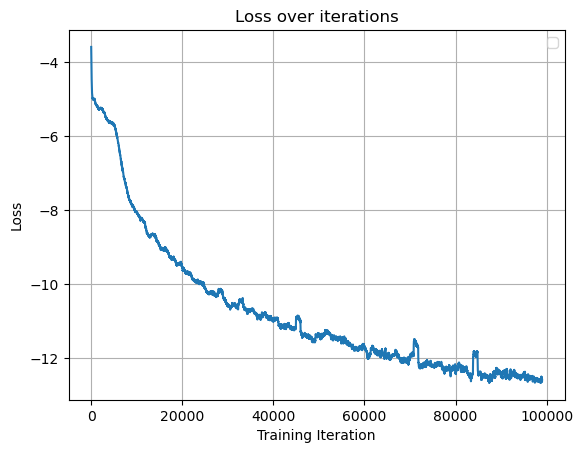

In [11]:
loss_data = np.array(loss_lst)

# Smoothing window size
window_size = 1000


smoothed_loss = np.convolve(loss_data, np.ones(window_size)/window_size, mode='valid')
lossX = [i for i in range(len(smoothed_loss))]

plt.plot(lossX, smoothed_loss)
plt.title("Loss over iterations")
plt.xlabel("Training Iteration")
plt.ylabel("Loss")
plt.grid()
plt.legend()
plt.show()

/tmp/ipykernel_5892/2903285880.py:55: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("model.pth"))


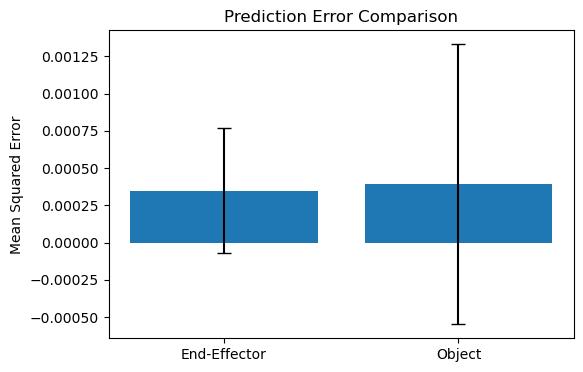

In [14]:
test()